# **Business Context and Problem Definition**

## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

### Import the libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math

from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [6]:
### Load the past data and New Data

In [7]:
past_data = pd.read_csv('INNHotelsGroup_pastdata.csv')
new_data = pd.read_csv('INNHotelsGroup_newdata.csv')

In [8]:
past_data.shape, new_data.shape

((27093, 12), (3583, 11))

In [9]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [10]:
new_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled


#### Lets understand exactly how many bookings were cancelled and rebooked at last moment from JAN-21 to JUL-22

In [12]:
# Lets see how many bookings were cancelled

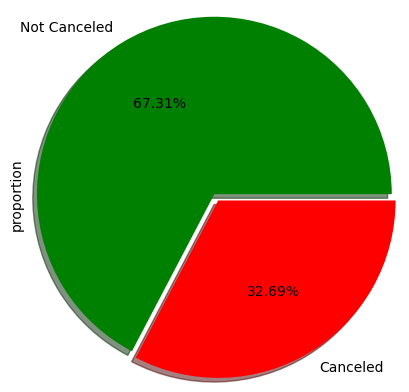

In [13]:
past_data['booking_status'].value_counts(normalize=True).plot(kind='pie', autopct = '%.2f%%',
                                                              radius= 1.2, colors = ['green','red'],
                                                             shadow=True, explode = [0,0.05])
plt.show()

In [14]:
# Lets see how many cancelled bookings were rebooked?

In [15]:
book_data = past_data[past_data['booking_status']=='Canceled']

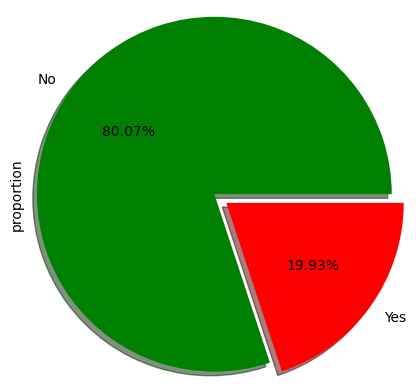

In [16]:
book_data['rebooked'].value_counts(normalize=True).plot(kind='pie', autopct = '%.2f%%',
                                                              radius= 1.2, colors = ['green','red'],
                                                             shadow=True, explode = [0,0.1])
plt.show()

Inference: Here we can see that out of all the bookings ~33% bookings are being cancelled and out of these cancelled bookings only ~20% are being rebooked. Hence, the Heuristic approach is not affective at all. The inventory losses are still very high.

## Exploring the Data

In [19]:
past_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27093 entries, 0 to 27092
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   booking_id                  27093 non-null  object 
 1   lead_time                   27093 non-null  int64  
 2   market_segment_type         27093 non-null  object 
 3   no_of_special_requests      27093 non-null  int64  
 4   avg_price_per_room          27093 non-null  float64
 5   no_of_adults                27093 non-null  int64  
 6   no_of_weekend_nights        27093 non-null  int64  
 7   arrival_date                27093 non-null  object 
 8   required_car_parking_space  27093 non-null  int64  
 9   no_of_week_nights           27093 non-null  int64  
 10  booking_status              27093 non-null  object 
 11  rebooked                    8857 non-null   object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.5+ MB


In [20]:
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [21]:
# booking id is a redundant column, let us set it as index
past_data.set_index('booking_id', inplace=True)
new_data.set_index('booking_id', inplace=True)

In [22]:
# We also need to change the data type of column 'arrival_date' to 'datetime'
past_data['arrival_date'] = pd.to_datetime(past_data['arrival_date'], format='%Y-%m-%d')
new_data['arrival_date'] = pd.to_datetime(new_data['arrival_date'], format='%Y-%m-%d')

In [23]:
num_cols = ['lead_time', 'avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests',
            'no_of_adults', 'no_of_weekend_nights', 
            'required_car_parking_space', 'no_of_week_nights',
            'booking_status', 'rebooked']

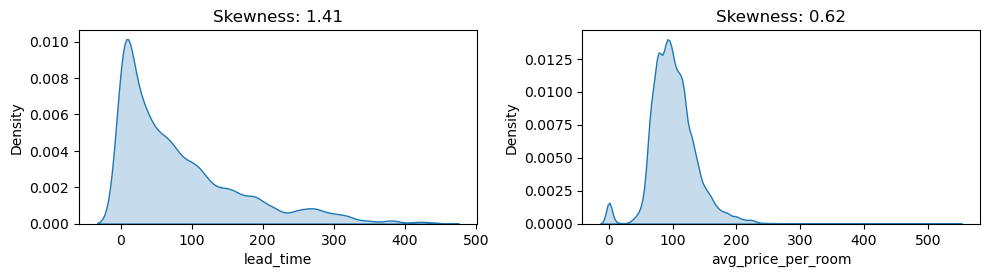

In [24]:
t = 1
plt.figure(figsize=(10,10))
for i in num_cols:
    plt.subplot(4,2,t)
    sns.kdeplot(data = past_data, x = i, fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

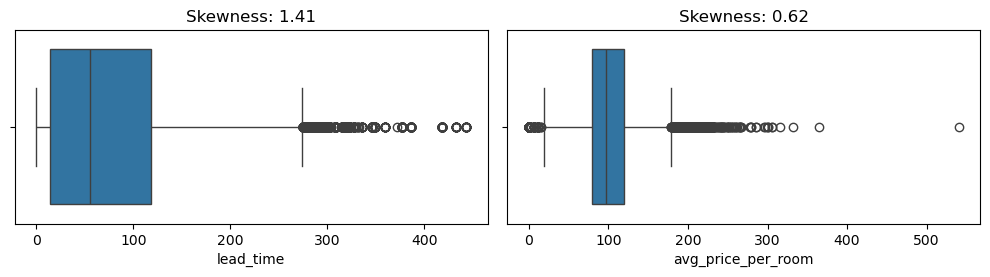

In [25]:
t = 1
plt.figure(figsize=(10,10))
for i in num_cols:
    plt.subplot(4,2,t)
    sns.boxplot(data = past_data, x = i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

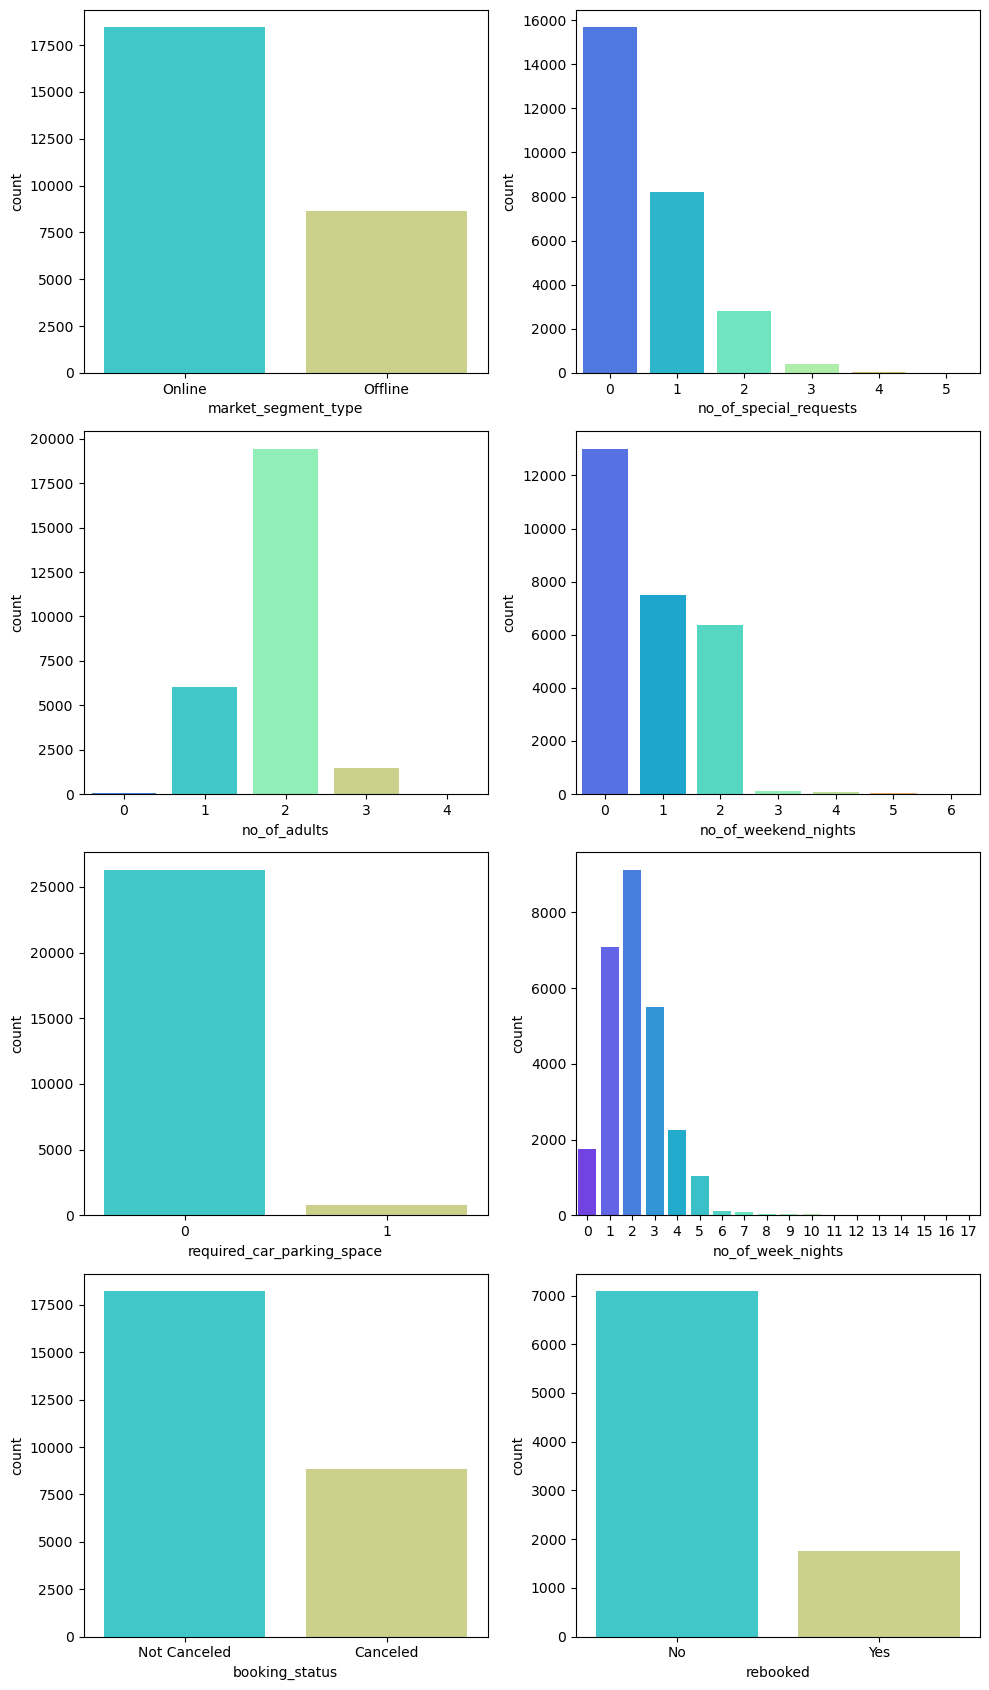

In [26]:
t = 1
plt.figure(figsize=(10,17))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data = past_data, x = i, palette='rainbow')
    t += 1
plt.tight_layout()
plt.show()

## Bivariate Analysis

In [28]:
# Num vs Cat

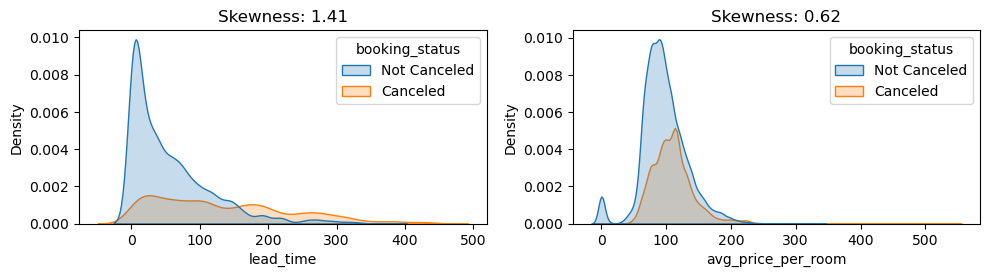

In [29]:
t = 1
plt.figure(figsize=(10,10))
for i in num_cols:
    plt.subplot(4,2,t)
    sns.kdeplot(data = past_data, x = i, hue='booking_status', fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

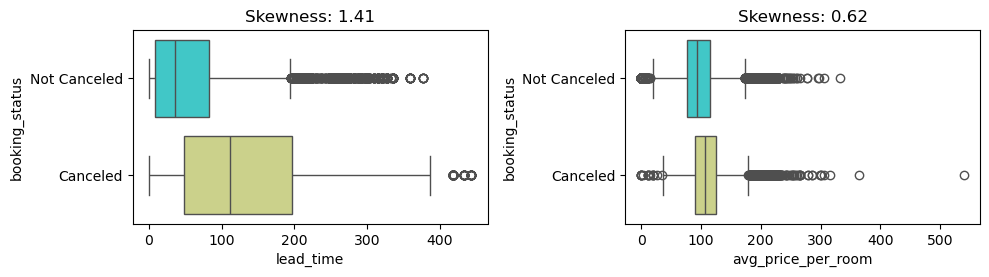

In [30]:
t = 1
plt.figure(figsize=(10,10))
for i in num_cols:
    plt.subplot(4,2,t)
    sns.boxplot(data = past_data, x = i, y ='booking_status', palette='rainbow')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

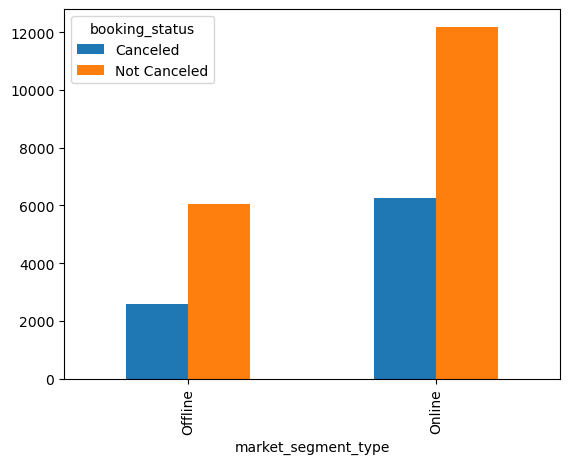

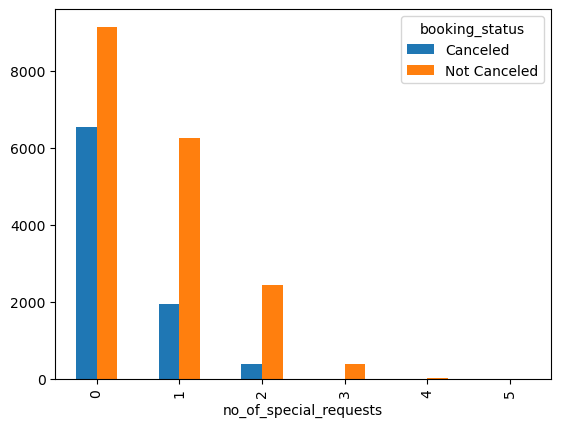

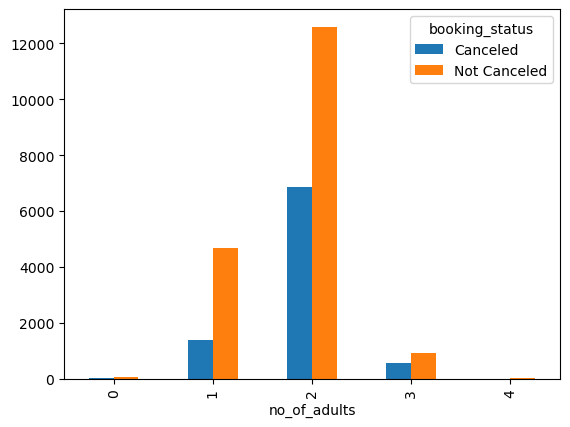

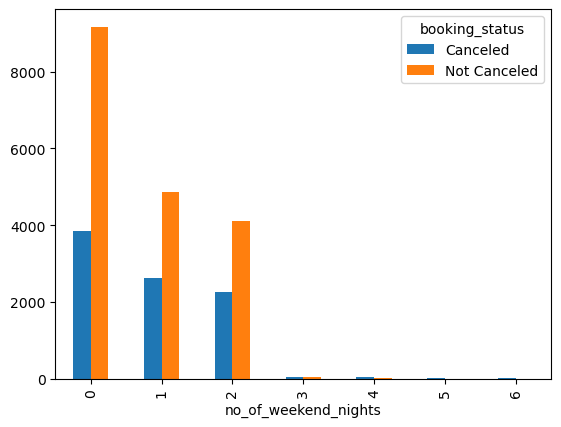

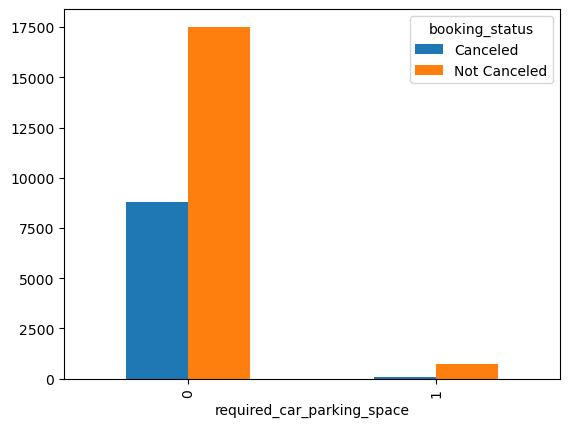

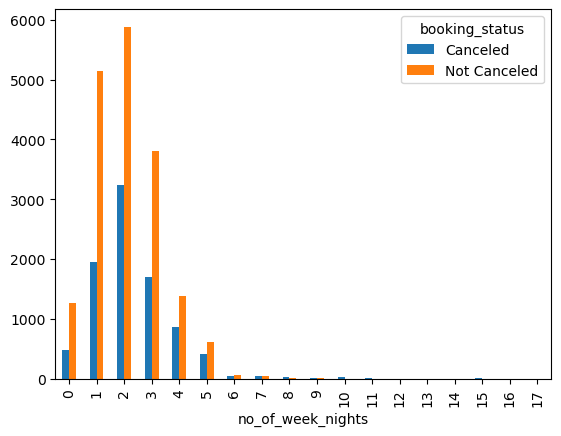

In [31]:
# Cat vs Cat (Grouped Bar Plot)
for i in cat_cols:
    if i != 'booking_status' and i != 'rebooked':
        pd.crosstab(past_data[i], past_data['booking_status']).plot(kind='bar')
plt.show()

## Multivariate Analysis

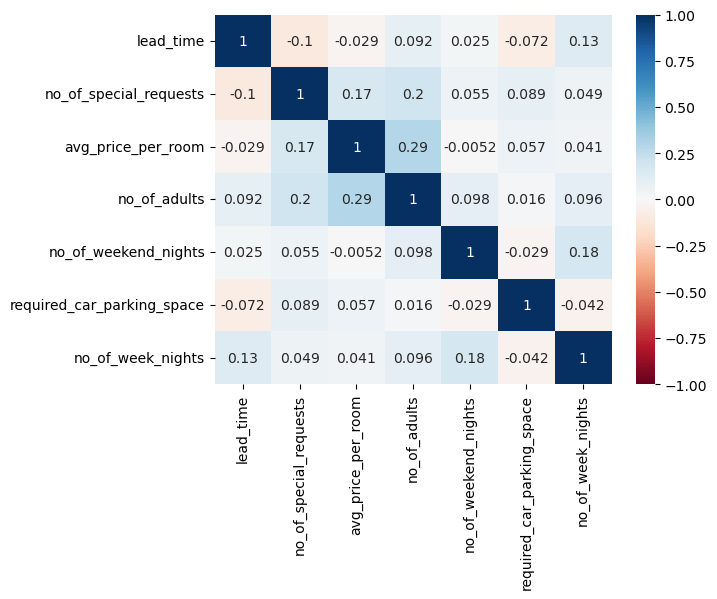

In [33]:
sns.heatmap(past_data.corr(numeric_only=True), annot=True, vmin=-1, cmap = 'RdBu')
plt.show()

# Inferential Statistics

In [35]:
# Lets statistically test the inference that we have made

In [36]:
# Lead_time vs Booking_status

samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']


# Lets go with 2 sample t-test
# Ho: mu1 = mu2 (Lead time doesnot affect the booking status)
# Ha: mu1 != mu2 (Lead time does affect the booking status)


# Assumption 1: Data must be normal (since sample size>30, let us assume it to be normal)


# Assumption 2: Variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  # p-value < 0.05 

# As variances of popl are not equal, hence lets go with Welch's t-test


print(stats.ttest_ind(samp1,samp2, equal_var=False))
# since p_value < 0.05, we reject Ho:
# Lead time does affect the booking status

LeveneResult(statistic=3210.120590252021, pvalue=0.0)
TtestResult(statistic=66.84799194126163, pvalue=0.0, df=12138.394836237343)


In [37]:
# average room price vs booking status

samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']


# Lets go with 2 sample t-test
# Ho: mu1 = mu2 (avg_price_per_room doesnot affect the booking status)
# Ha: mu1 != mu2 (avg_price_per_room does affect the booking status)


# Assumption 1: Data must be normal (since sample size>30, let us assume it to be normal)


# Assumption 2: Variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  # p-value < 0.05 

# As variances of popl are not equal, hence lets go with Welch's t-test


print(stats.ttest_ind(samp1,samp2, equal_var=False))
# since p_value < 0.05, we reject Ho:
# Avg_price_per_room does affect the booking status

LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)
TtestResult(statistic=29.9727805387597, pvalue=8.462441935004689e-193, df=18575.27155776574)


In [38]:
# all cat columns vs booking status

# chi-square test for independence
# Ho: No relation in categories
# Ha: There is relation in categories

for i in cat_cols:
    if i not in ['booking_status', 'rebooked']:
        ct = pd.crosstab(past_data['booking_status'], past_data[i])
        print(i, stats.chi2_contingency(ct)[1])

# Since, pvalue for all cat cols is < 0.05
# all are statistically significant

market_segment_type 7.806389643886697e-11
no_of_special_requests 0.0
no_of_adults 1.441185511500568e-73
no_of_weekend_nights 5.324997086476798e-43
required_car_parking_space 5.626905783478662e-49
no_of_week_nights 7.318602549508705e-65


## Data Pre-Processing

In [40]:
# Lets remove the 'rebooked' from predictive modelling as this info will not be available for future data 

In [41]:
past_data.drop(columns='rebooked', inplace=True)

In [42]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled


In [43]:
past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [44]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

## Outlier Treatment

In [46]:
# lets cap the extreme outliers

In [47]:
for i in num_cols:
    q1,q3 = np.quantile(past_data[i],[0.25,0.75])
    iqr = q3-q1
    ul, ll  = q3 + 2.5*iqr, q1 - 2.5*iqr
    past_data[i] = past_data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

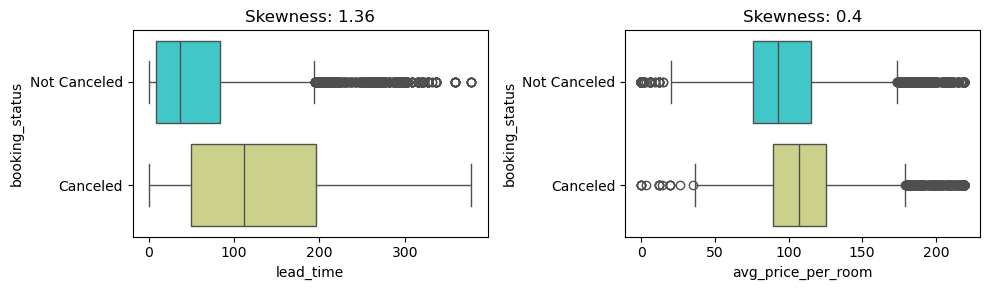

In [48]:
t = 1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data = past_data, x = i, y ='booking_status', palette='rainbow')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

### Feature Encoding

In [50]:
past_data = pd.get_dummies(past_data, columns=['market_segment_type'], drop_first=True, dtype=int)
new_data = pd.get_dummies(new_data, columns=['market_segment_type'], drop_first=True, dtype=int)

In [51]:
# ordinal encoding for booking status
past_data['booking_status'] = past_data['booking_status'].map({'Canceled':1, 'Not Canceled':0})

In [52]:
new_data['booking_status'] = new_data['booking_status'].map({'Canceled':1, 'Not Canceled':0})

In [53]:
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_101034,0.0,0,85.03,1,1,2021-01-01,0,0,0,1
INNHG_101035,34.0,2,125.10,2,2,2021-01-01,0,0,0,1


## Feature Transformation

In [55]:
transformer = PowerTransformer(standardize=False)

In [56]:
past_data[num_cols] = transformer.fit_transform(past_data[num_cols])
new_data[num_cols] = transformer.transform(new_data[num_cols])

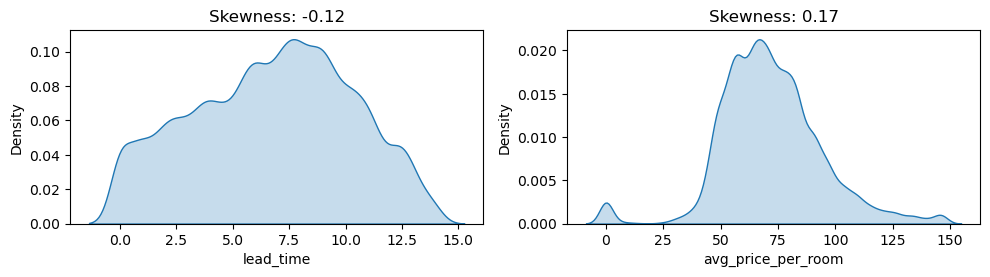

In [57]:
t = 1
plt.figure(figsize=(10,10))
for i in num_cols:
    plt.subplot(4,2,t)
    sns.kdeplot(data = past_data, x = i, fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t += 1
plt.tight_layout()
plt.show()

## Feature Engineering (generate new columns)

In [59]:
new_data.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,2022-07-01,1,1,0,1
INNHG_128128,10.093647,2,73.991462,2,2,2022-07-01,0,2,0,1
INNHG_128129,6.367294,1,88.952344,2,1,2022-07-01,1,2,0,1
INNHG_128130,10.045146,0,53.538501,2,0,2022-07-01,0,1,0,0
INNHG_128131,8.319177,1,76.584604,2,1,2022-07-01,0,2,0,0


In [60]:
# Lets extract month and weekday from date of arrival

In [61]:
past_data['arrival_month'] = past_data['arrival_date'].dt.month
past_data['arrival_wkday'] = past_data['arrival_date'].dt.weekday

In [62]:
past_data.drop(columns='arrival_date', inplace=True)

In [63]:
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4


In [64]:
new_data['arrival_month'] = new_data['arrival_date'].dt.month
new_data['arrival_wkday'] = new_data['arrival_date'].dt.weekday

new_data.drop(columns='arrival_date', inplace=True)

In [65]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4


In [66]:
# We can add number of weekdays and weekends in the booking and get stay duration
past_data['total_nights'] = past_data['no_of_week_nights'] + past_data['no_of_weekend_nights']

In [67]:
new_data['total_nights'] = new_data['no_of_week_nights'] + new_data['no_of_weekend_nights']

In [68]:
# we can also calculate the departure day from total_nights and arrival_weekday
past_data['depart_wkday'] = (past_data['arrival_wkday']+past_data['total_nights'])%7

In [69]:
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4,1,5
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4,2,6


In [70]:
new_data['depart_wkday'] = (new_data['arrival_wkday']+new_data['total_nights'])%7

In [71]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4,1,5
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4,4,1


# Predictive Modeling

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier)
from xgboost import XGBClassifier

from sklearn.metrics import (roc_auc_score, roc_curve, classification_report, cohen_kappa_score, 
                            accuracy_score, recall_score, precision_score, f1_score)

from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score)


### Train_Test_Split

In [75]:
y_train = past_data['booking_status']
x_train = past_data.drop(columns=['booking_status'])

y_test = new_data['booking_status']
x_test = new_data.drop(columns=['booking_status'])

In [76]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(27093, 12) (27093,)
(3583, 12) (3583,)


## Modular Coding (Creating functions for tasks)

In [78]:
def model_train(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]

    return m, pred_h, pred_s

In [79]:
def model_score(predh,preds,ytest=y_test):
    print('Classification Report')
    print(classification_report(ytest,predh))

    fpr, tpr, thres = roc_curve(ytest,preds)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1], color='red', ls = '--')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,preds),4)}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [80]:
def model_tuning(model,grid,x=x_train,y=y_train,folds=6,score='roc_auc'):

    gscv = GridSearchCV(estimator=model, param_grid=grid, scoring=score, cv=folds, verbose=1, n_jobs=5)
    gscv.fit(x,y)
    print('Best Score', gscv.best_score_)
    return gscv.best_params_

In [81]:
mod = []
accu = []
rec = []
prec = []
f1 = []
ck = []
auc = []

In [82]:
def model_scorecard(model,predh,preds,ytest=y_test):
    mod.append(str(model))
    accu.append(accuracy_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    prec.append(precision_score(ytest,predh))
    f1.append(f1_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))

    scorecard = pd.DataFrame({'Accuracy':accu,'Precision':prec,'Recall':rec,'F1':f1,'Cohen Kappa':ck,'ROC AUC':auc},index=mod)
    return scorecard

### Logistic Regression

In [84]:
model_lr, predh_lr, preds_lr = model_train(LogisticRegression(class_weight='balanced'),
                                          x_train, y_train, x_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      2383
           1       0.56      0.77      0.65      1200

    accuracy                           0.72      3583
   macro avg       0.71      0.73      0.71      3583
weighted avg       0.76      0.72      0.73      3583



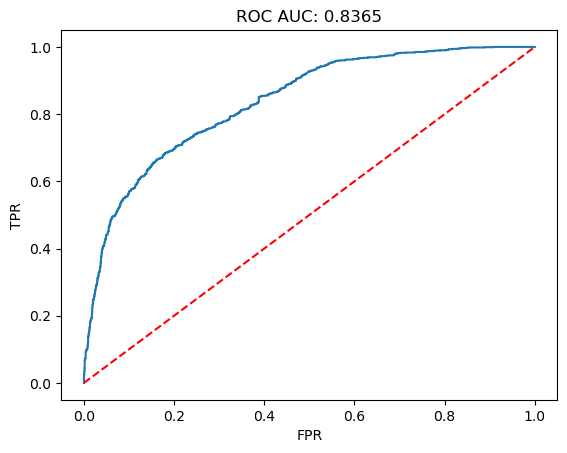

In [85]:
model_score(predh_lr, preds_lr)

In [86]:
model_scorecard(model_lr,predh_lr,preds_lr)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502


### Naive Bayes'

In [88]:
model_gnb,predh_gnb,preds_gnb = model_train(GaussianNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2383
           1       0.56      0.61      0.58      1200

    accuracy                           0.71      3583
   macro avg       0.68      0.68      0.68      3583
weighted avg       0.71      0.71      0.71      3583



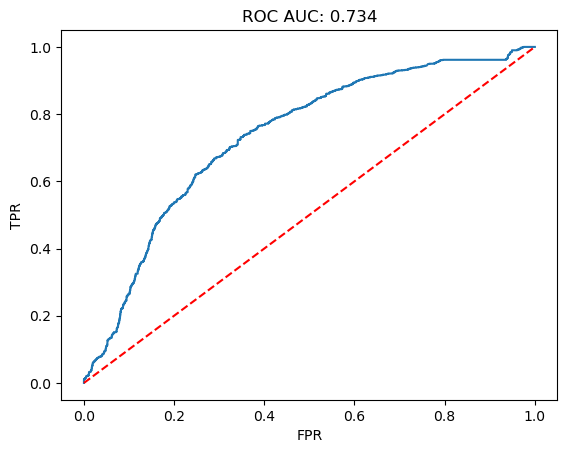

In [89]:
model_score(predh_gnb, preds_gnb)

In [90]:
model_scorecard(model_gnb,predh_gnb,preds_gnb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


In [91]:
model_mnb,predh_mnb,preds_mnb = model_train(MultinomialNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      2383
           1       0.72      0.14      0.23      1200

    accuracy                           0.69      3583
   macro avg       0.71      0.56      0.52      3583
weighted avg       0.70      0.69      0.62      3583



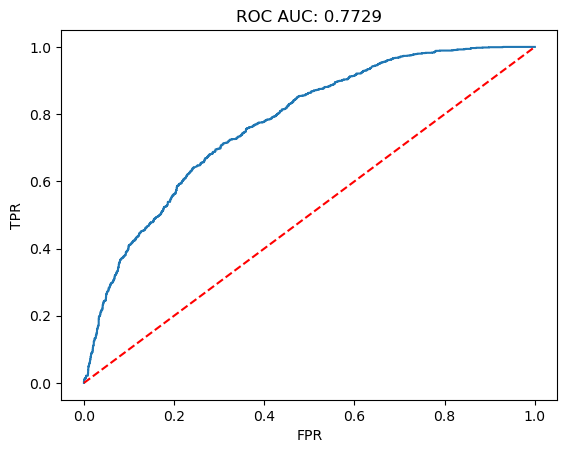

In [92]:
model_score(predh_mnb, preds_mnb)

In [93]:
model_scorecard(model_mnb,predh_mnb, preds_mnb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855


### Decision Tree

In [95]:
tuned_params = model_tuning(DecisionTreeClassifier(class_weight='balanced'),
            {'max_depth':[5,7,9,11,13], 'max_leaf_nodes':[22,23,24,25,26,27]})

Fitting 6 folds for each of 30 candidates, totalling 180 fits
Best Score 0.8078153757188048


In [96]:
model_dt, predh_dt, preds_dt = model_train(DecisionTreeClassifier(class_weight='balanced',**tuned_params),
                                          x_train,y_train,x_test,y_test)

In [97]:
tuned_params

{'max_depth': 9, 'max_leaf_nodes': 26}

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2383
           1       0.65      0.73      0.69      1200

    accuracy                           0.78      3583
   macro avg       0.75      0.77      0.76      3583
weighted avg       0.79      0.78      0.78      3583



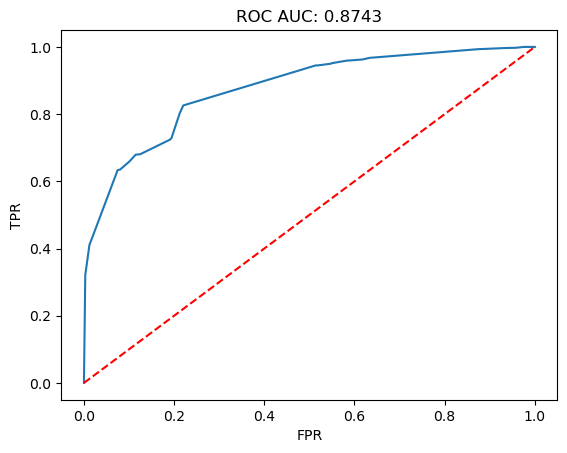

In [98]:
model_score(predh_dt, preds_dt)

In [99]:
model_scorecard(model_dt,predh_dt, preds_dt)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321


## Random Forest

In [101]:
tuned_params=model_tuning(RandomForestClassifier(max_features=None, class_weight='balanced'),
                   grid={'n_estimators':[50,60,70,80,90],'max_depth':[5,6,7,8]})

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Best Score 0.7907358218562468


In [102]:
model_rf, predh_rf, preds_rf = model_train(RandomForestClassifier(max_features=None,**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.79      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.81      0.81      3583
weighted avg       0.84      0.84      0.84      3583



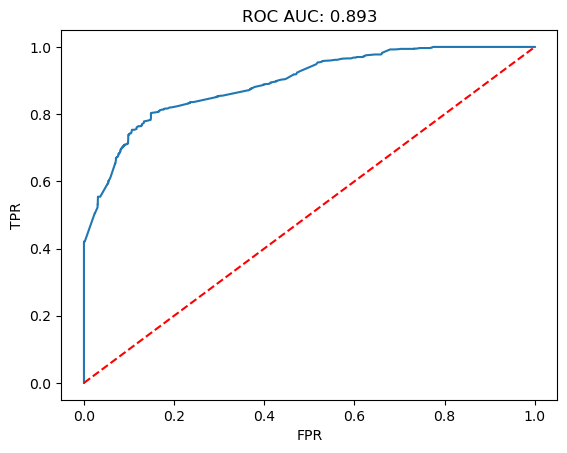

In [103]:
model_score(predh_rf, preds_rf)

In [104]:
model_scorecard(model_rf,predh_rf, preds_rf)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959


## XG Boost

In [106]:
tuned_params=model_tuning(XGBClassifier(),
                   grid={'gamma': [7,8,9,10,11,12], 'n_estimators': [42,45,48], 'reg_lambda': [1,2,3,4]})

Fitting 6 folds for each of 72 candidates, totalling 432 fits
Best Score 0.76406400818887


In [107]:
tuned_params

{'gamma': 10, 'n_estimators': 42, 'reg_lambda': 3}

In [108]:
model_xgb, predh_xgb, preds_xgb = model_train(XGBClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2383
           1       0.77      0.71      0.74      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.80      0.81      3583
weighted avg       0.83      0.83      0.83      3583



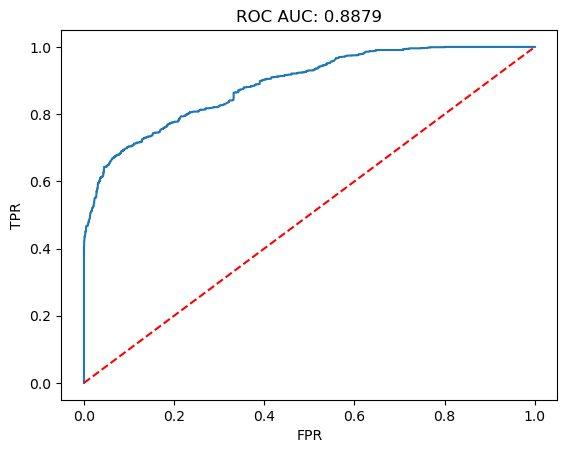

In [109]:
model_score(predh_xgb, preds_xgb)

In [110]:
model_scorecard(model_xgb,predh_xgb, preds_xgb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=10, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=42,\n n_jobs=None, num_parallel_tree=None, ...)",0.830868,0.770000,0.705833,0.736522,0.612331,0.887884


## Adaptive Boosting

In [112]:
tuned_params=model_tuning(AdaBoostClassifier(),
                   grid={'learning_rate': [0.01,0.05,0.1,0.5], 'n_estimators': [55,60,65,70,75]})

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Best Score 0.8263437219757054


In [113]:
tuned_params

{'learning_rate': 0.1, 'n_estimators': 70}

In [114]:
model_ada, predh_ada, preds_ada = model_train(AdaBoostClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2383
           1       0.75      0.51      0.61      1200

    accuracy                           0.78      3583
   macro avg       0.77      0.71      0.73      3583
weighted avg       0.77      0.78      0.77      3583



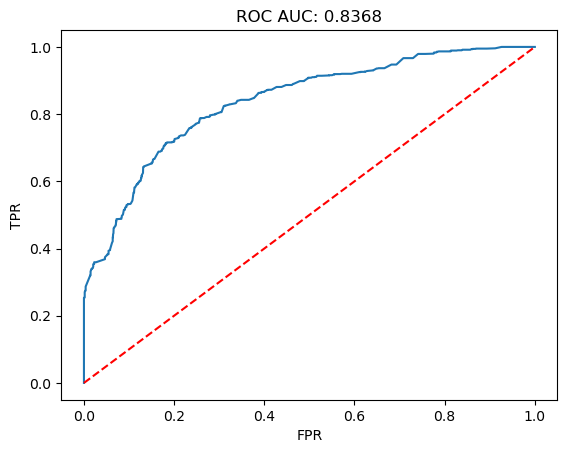

In [115]:
model_score(predh_ada, preds_ada)

In [116]:
model_scorecard(model_ada,predh_ada, preds_ada)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=10, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=42,\n n_jobs=None, num_parallel_tree=None, ...)",0.830868,0.770000,0.705833,0.736522,0.612331,0.887884
"AdaBoostClassifier(learning_rate=0.1, n_estimators=70)",0.778398,0.745169,0.514167,0.608481,0.461103,0.836830


## Gradient Boosting

In [118]:
tuned_params = model_tuning(GradientBoostingClassifier(random_state=2), grid = {'n_estimators':[85,90,95], 
                                                                                 'learning_rate':[0.01,0.05],
                                                                                'max_depth':[6,7]})

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Score 0.761690626675922


In [119]:
tuned_params

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 90}

In [120]:
model_gb, predh_gb, preds_gb = model_train(GradientBoostingClassifier(random_state=2,**tuned_params),
                                              x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2383
           1       0.86      0.59      0.70      1200

    accuracy                           0.83      3583
   macro avg       0.84      0.77      0.79      3583
weighted avg       0.83      0.83      0.82      3583



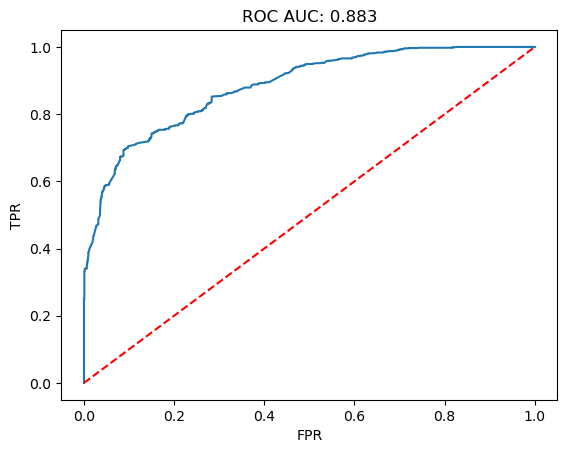

In [121]:
model_score(predh_gb, preds_gb)

In [122]:
model_scorecard(model_gb,predh_gb, preds_gb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=10, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=42,\n n_jobs=None, num_parallel_tree=None, ...)",0.830868,0.770000,0.705833,0.736522,0.612331,0.887884
"AdaBoostClassifier(learning_rate=0.1, n_estimators=70)",0.778398,0.745169,0.514167,0.608481,0.461103,0.836830
"GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=90,\n random_state=2)",0.829473,0.857837,0.588333,0.697973,0.584842,0.882960


## Voting

In [124]:
base_estimators = [('RF',model_rf),
                   ('GBM',model_gb),
                   ('XGB',model_xgb)]

In [125]:
model_vot = VotingClassifier(estimators=base_estimators, voting='soft')


# voting='soft' --- can give both hard and soft predictions
# voting='hard' --- can give only the hard predictions

In [126]:
model_vot.fit(x_train,y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=5,
                                                     max_features=None,
                                                     n_estimators=50)),
                             ('GBM',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=7,
                                                         n_estimators=90,
                                                         random_state=2)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            ea...
                                            feature_weights=None, gamma=10,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=42, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [127]:
predh_vot = model_vot.predict(x_test)

In [128]:
preds_vot = model_vot.predict_proba(x_test)[:,1]

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2383
           1       0.82      0.70      0.76      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.81      0.82      3583
weighted avg       0.85      0.85      0.84      3583



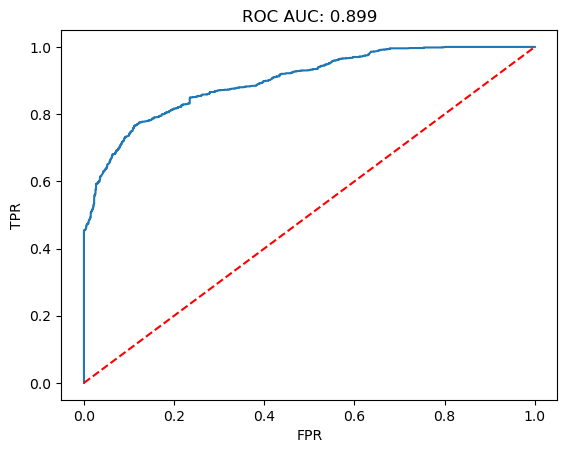

In [129]:
model_score(predh_vot, preds_vot)

In [130]:
scorecard = model_scorecard(model_vot,predh_vot, preds_vot)

In [131]:
scorecard.sort_values(by='ROC AUC', ascending=False)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(max_depth=5,\n max_features=None,\n n_estimators=50)),\n ('GBM',\n GradientBoostingClassifier(learning_rate=0.01,\n max_depth=7,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=None,\n ea...\n feature_weights=None, gamma=10,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=None, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=42, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.847614,0.817476,0.701667,0.755157,0.645472,0.899048
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=10, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=42,\n n_jobs=None, num_parallel_tree=None, ...)",0.830868,0.770000,0.705833,0.736522,0.612331,0.887884
"GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=90,\n random_state=2)",0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"AdaBoostClassifier(learning_rate=0.1, n_estimators=70)",0.778398,0.745169,0.514167,0.608481,0.461103,0.836830
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


## Stacking

In [133]:
model_stack = StackingClassifier(cv=6, estimators=base_estimators)

In [134]:
model_stack.fit(x_train,y_train)

StackingClassifier(cv=6,
                   estimators=[('RF',
                                RandomForestClassifier(max_depth=5,
                                                       max_features=None,
                                                       n_estimators=50)),
                               ('GBM',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=7,
                                                           n_estimators=90,
                                                           random_state=2)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=...
                                              feature_weights=None, gamma=10,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=42, n_jobs=None,
                                              num_parallel_tree=None, ...))])

In [135]:
predh_stack = model_stack.predict(x_test)
preds_stack = model_stack.predict_proba(x_test)[:,1]

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      2383
           1       0.83      0.65      0.73      1200

    accuracy                           0.84      3583
   macro avg       0.84      0.79      0.81      3583
weighted avg       0.84      0.84      0.84      3583



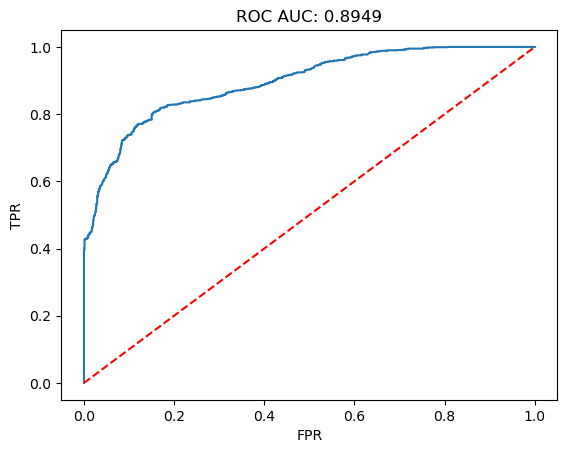

In [136]:
model_score(predh_stack,preds_stack)

In [137]:
scorecard = model_scorecard(model_stack,predh_stack, preds_stack)

In [138]:
scorecard.sort_values(by='ROC AUC', ascending=False)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(max_depth=5,\n max_features=None,\n n_estimators=50)),\n ('GBM',\n GradientBoostingClassifier(learning_rate=0.01,\n max_depth=7,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=None,\n ea...\n feature_weights=None, gamma=10,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=None, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=42, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.847614,0.817476,0.701667,0.755157,0.645472,0.899048
"StackingClassifier(cv=6,\n estimators=[('RF',\n RandomForestClassifier(max_depth=5,\n max_features=None,\n n_estimators=50)),\n ('GBM',\n GradientBoostingClassifier(learning_rate=0.01,\n max_depth=7,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None,\n device=...\n feature_weights=None, gamma=10,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=None, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None,\n max_depth=None, max_leaves=None,\n min_child_weight=None,\n missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=42, n_jobs=None,\n num_parallel_tree=None, ...))])",0.840636,0.834931,0.653333,0.733053,0.621862,0.894940
"RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)",0.839241,0.787823,0.711667,0.747811,0.630273,0.892959
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=10, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=42,\n n_jobs=None, num_parallel_tree=None, ...)",0.830868,0.770000,0.705833,0.736522,0.612331,0.887884
"GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=90,\n random_state=2)",0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
"DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=26)",0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
"AdaBoostClassifier(learning_rate=0.1, n_estimators=70)",0.778398,0.745169,0.514167,0.608481,0.461103,0.836830
LogisticRegression(class_weight='balanced'),0.721462,0.561064,0.773333,0.650315,0.428441,0.836502
MultinomialNB(),0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
GaussianNB(),0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


## Final Model

In [140]:
# we choose voting as our final model as it has the best ROC AUC
# now we will check for overfitting
# we will also check if we can improve the scores in 1 by changing the cutoff classifiers

In [141]:
scores = cross_val_score(estimator=model_vot, cv=KFold(n_splits=7,shuffle=True, random_state=2),
                        scoring='roc_auc',X=x_train, y=y_train, n_jobs=5, verbose=1)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:   29.8s finished


In [142]:
scores

array([0.91879904, 0.91906625, 0.92103101, 0.91341559, 0.9262592 ,
       0.93001012, 0.9182993 ])

In [143]:
# let us now try to improve score in class 1
fpr, tpr, thres = roc_curve(y_test,preds_vot)

In [144]:
pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thres':thres, 'Yodens Index':tpr*(1-fpr)}).sort_values(by='Yodens Index', ascending=False)

,FPR,TPR,Thres,Yodens Index
465,0.123374,0.775833,0.395407,0.680116
463,0.122535,0.775000,0.399049,0.680036
448,0.112463,0.765833,0.415714,0.679705
447,0.111624,0.765000,0.415755,0.679608
450,0.113722,0.766667,0.414855,0.679480
...,...,...,...,...
1290,0.996643,1.000000,0.049777,0.003357
2,0.000000,0.002500,0.884229,0.002500
1,0.000000,0.000833,0.884329,0.000833
0,0.000000,0.000000,inf,0.000000


In [145]:
predh_vot_new = (preds_vot>0.402856).astype(int)

In [146]:
print(classification_report(y_test,predh_vot_new))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2383
           1       0.76      0.77      0.77      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.83      0.82      3583
weighted avg       0.84      0.84      0.84      3583



# Deployment

In [148]:
x_test.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,1,7,4,1,5
INNHG_128128,10.093647,2,73.991462,2,2,0,2,1,7,4,4,1


In [149]:
# suppose a new customer is making a booking, I want to predict its cancellation charges

In [150]:
x_test.columns

Index(['lead_time', 'no_of_special_requests', 'avg_price_per_room',
       'no_of_adults', 'no_of_weekend_nights', 'required_car_parking_space',
       'no_of_week_nights', 'market_segment_type_Online', 'arrival_month',
       'arrival_wkday', 'total_nights', 'depart_wkday'],
      dtype='object')

In [151]:
lt = 10
spcl = 0
price = 120
nad = 2
wend = 2
park = 0
week = 1
mark = 1
arv = 5
arvw = 4
tot = 3
depw = 0

In [152]:
lt_t, price_t = transformer.transform([[lt,price]])[0]

In [153]:
model_vot.predict_proba([[lt_t, spcl, price_t, nad, wend,park,week,mark,arv,arvw,tot,depw]])[:,1]

array([0.50819181])

In [154]:
x_test.iloc[0:1,:]

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,1,7,4,1,5


In [155]:
# Lets create some files to save our final model
import joblib

In [235]:
with open('final_model.joblib', 'wb') as file:
    joblib.dump(model_vot, file)

In [236]:
with open('transformer.joblib', 'wb') as file:
    joblib.dump(transformer, file)